## VCB

# NON OPTIMIZER

In [49]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Nadam

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../../Dataset/VCB.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (70/30)
train_size = int(len(y_norm) * 0.7)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error')
history_non = model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=32, verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)
future_predictions_non = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/200


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0479 - val_loss: 0.0012
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.5393e-04 - val_loss: 0.0014
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7467e-04 - val_loss: 0.0012
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1122e-04 - val_loss: 8.7423e-04
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9512e-04 - val_loss: 7.9276e-04
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.9257e-04 - val_loss: 7.9399e-04
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4886e-04 - val_loss: 8.2772e-04
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2814e-04 - val_loss: 7.8272e-04
Epoch 12/200
50/50 ━━━━━━━━

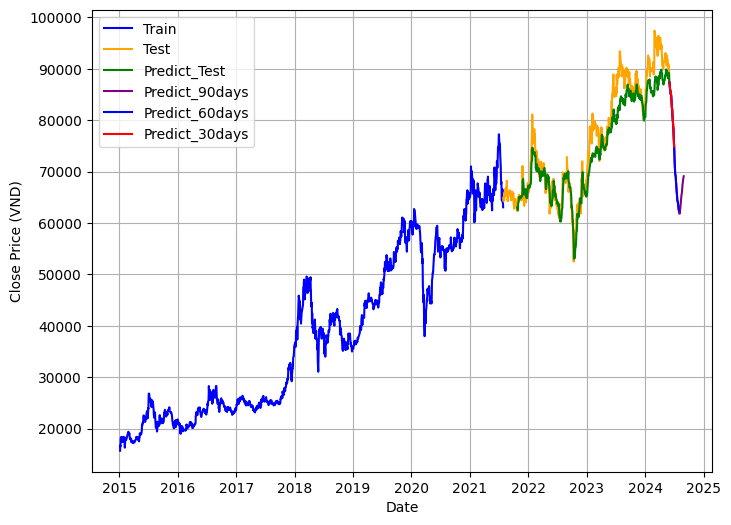

In [50]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates, future_predictions_non, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions_non[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions_non[:30], label='Predict_30days', color='red')

# plt.title('VCB Stock Price Forecast using LSTM 7:3')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 3415.4639085716462
MAPE: 3.2477515825724517 %
MAE: 2610.4954427083326


# NADAM

In [52]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Nadam

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../../Dataset/VCB.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (70/30)
train_size = int(len(y_norm) * 0.7)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(n_forecast))

optimizer = Nadam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
history_nadam = model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=32, verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)
future_predictions_nadam = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/200


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0203 - val_loss: 0.0034
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.2185e-04 - val_loss: 0.0017
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6717e-04 - val_loss: 0.0015
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8242e-04 - val_loss: 0.0013
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4511e-04 - val_loss: 9.7313e-04
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1914e-04 - val_loss: 7.9843e-04
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0033e-04 - val_loss: 6.6470e-04
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8064e-04 - val_loss: 5.5674e-04
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6640e-04 - val_loss: 5.1098e-04
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5730e-04 - val_loss: 4.8411e-04
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5043e-04 - val_loss: 4.7611e-04
Epoch 1

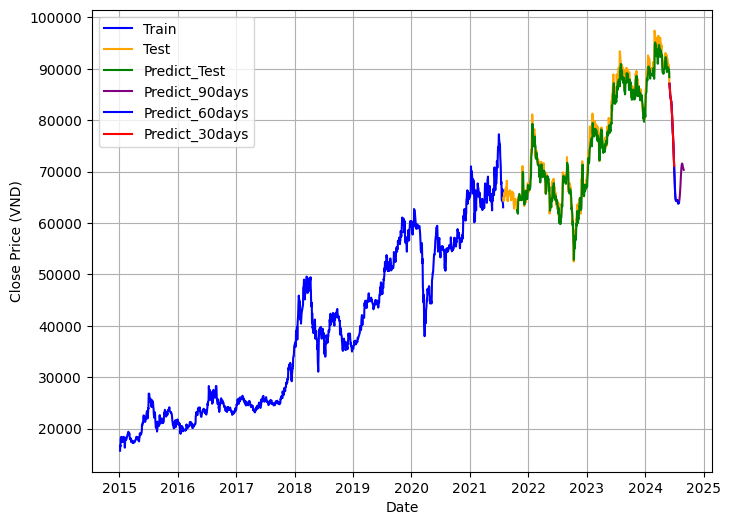

In [53]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates, future_predictions_nadam, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions_nadam[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions_nadam[:30], label='Predict_30days', color='red')

# plt.title('VCB Stock Price Forecast using LSTM 7:3')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 1573.6732537298985
MAPE: 1.613051883239024 %
MAE: 1234.0602609034265


# ADADELTA

In [55]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../../Dataset/VCB.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (70/30)
train_size = int(len(y_norm) * 0.7)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) 
model.add(Dense(50, activation='relu'))                            
model.add(Dense(n_forecast))                                       
model.compile(loss='mean_squared_error', optimizer='adadelta')
history_adadelta = model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=32, verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions_adelta = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/200


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1038 - val_loss: 0.4853
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0979 - val_loss: 0.4562
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0921 - val_loss: 0.4278
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0864 - val_loss: 0.4003
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0809 - val_loss: 0.3736
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0755 - val_loss: 0.3477
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0704 - val_loss: 0.3228
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0654 - val_loss: 0.2988
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0606 - val_loss: 0.2757
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0560 - val_loss: 0.2536
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0516 - val_loss: 0.2325
Epoch 12/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0473 - val_lo

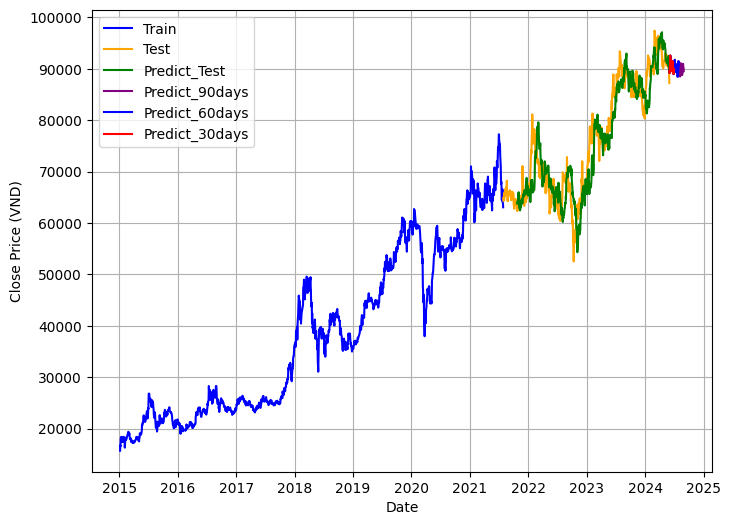

In [56]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates, future_predictions_adelta, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions_adelta[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions_adelta[:30], label='Predict_30days', color='red')

# plt.title('VCB Stock Price Forecast using LSTM 7:3')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 3957.985151341174
MAPE: 4.142007954645637 %
MAE: 3077.625328563084


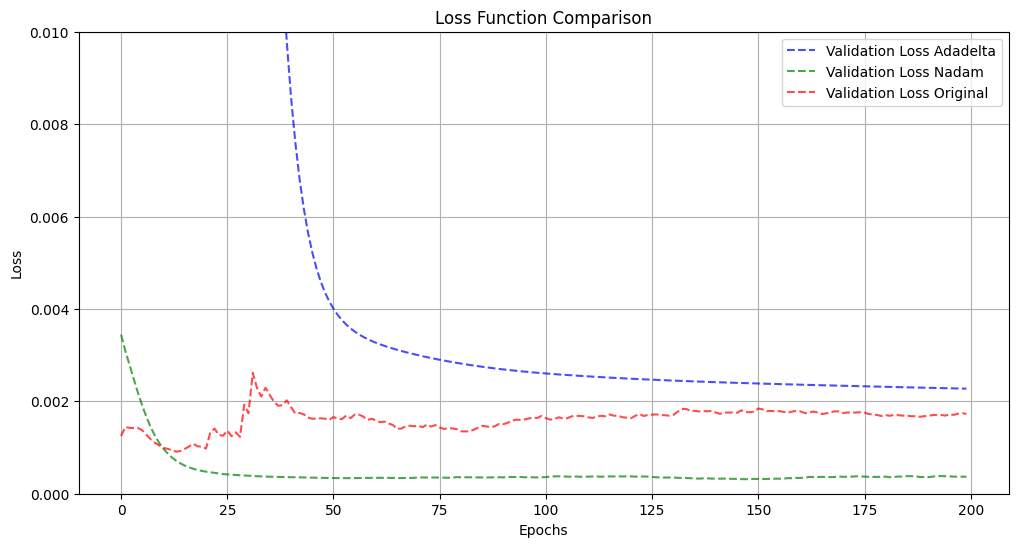

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Giả sử rằng bạn đã có lịch sử huấn luyện từ các mô hình với các optimizer khác nhau
# Ví dụ: history_adadelta, history_nadam, history_non

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Sử dụng hàm làm mịn
smooth_adadelta_loss = smooth_curve(history_adadelta.history['loss'])
smooth_adadelta_val_loss = smooth_curve(history_adadelta.history['val_loss'])
smooth_nadam_loss = smooth_curve(history_nadam.history['loss'])
smooth_nadam_val_loss = smooth_curve(history_nadam.history['val_loss'])
smooth_adam_loss = smooth_curve(history_non.history['loss'])
smooth_adam_val_loss = smooth_curve(history_non.history['val_loss'])

# Vẽ biểu đồ hàm mất mát với các điều chỉnh để rõ ràng hơn và đường biểu diễn mượt hơn
plt.figure(figsize=(12, 6))

# Loss function của model với optimizer Adadelta
plt.plot(smooth_adadelta_val_loss, label='Validation Loss Adadelta', color='blue', linestyle='--', alpha=0.7)

# Loss function của model với optimizer Nadam
plt.plot(smooth_nadam_val_loss, label='Validation Loss Nadam', color='green', linestyle='--', alpha=0.7)

# Loss function của model với optimizer mặc định (Adam)
plt.plot(smooth_adam_val_loss, label='Validation Loss Original', color='red', linestyle='--', alpha=0.7)

# Định dạng biểu đồ
plt.title('Loss Function Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 0.01)  # Giới hạn trục y để loại bỏ các giá trị ngoại lai
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()


## CTG

## BID

In [59]:
code = "VCB"
split = 0.9

In [60]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Nadam

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv(f'../../Dataset/{code}.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (70/30)
train_size = int(len(y_norm) * split)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(n_lookback,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(n_forecast))

optimizer = Nadam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
history_nadam = model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=32, verbose=0)

# Evaluate on the test set
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)
future_predictions_nadam = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

In [61]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 2521.4976818471396
MAPE: 2.5752272325306946 %
MAE: 2290.0598060344846
